In [5]:
from lib.controller import Controller
from lib.automation import FileDetector
import time
import random
import os
from lib.utilities import *
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull

In [6]:
data_dir = "C:/Users/jjudge3/Desktop/Data/06-21-22/"
camera_program = 4

slice_target = 6
rec_target = 1

In [7]:
# read in 8-bit single TIF images to array, apply same cropping/binning
dic_dir = data_dir + "dic/"
single_images = {}

cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(cam_settings['height'] / 80)
for filename in os.listdir(dic_dir):
    if filename.endswith(".tif"):
        sd = Dataset(dic_dir + filename)
        sd.clip_data(y_range=cam_settings['cropping'],
                    t_range=[0,1])
        sd.bin_data(binning=binning)
        img = sd.get_data()
        meta = sd.get_meta()
        slic = meta['slice_number']
        loc = meta['location_number']
        img_type = meta['img_type']
        if slic not in single_images:
            single_images[slic] = {}
        if loc not in single_images[slic]:
            single_images[slic][loc] = {}
        
        single_images[slic][loc][img_type] = img[0,0,:,:]
        if slic == slice_target and img_type == 'e':
            plt.imshow(single_images[slic][loc][img_type],
                      cmap="gray")


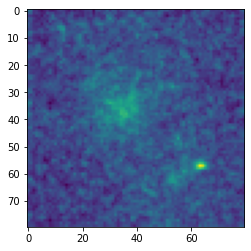

In [8]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat"):
        map_type = filename[:3]
        name_parse = filename.split('.')[0][-8:]
        slic, loc, rec = [int(x) for x in name_parse.split('_')]
        if map_type not in single_images[slic][loc]:
            single_images[slic][loc][map_type] = {}
        dat = np.loadtxt(dat_dir + filename,
                         delimiter='\t',
                         usecols=(1,))
        width = int(np.sqrt(dat.shape[0]))
        dat = dat.reshape((width, width))
        if map_type == "SNR" and slic == slice_target and rec == rec_target:
            plt.imshow(dat)
        single_images[slic][loc][map_type][rec] = dat
        

In [9]:
# record stim amplitudes manually
stims = {}
single_images[1][1]['stims'] = [100, 100, 100, 80, 80, 60, 60, 40, 40]
single_images[2][1]['stims'] = [40, 100, 100, 80, 80, 60, 60]
single_images[3][1]['stims'] = [100, 100, 80, 80, 60, 60]

In [25]:
def generate_points(snr_map, n_points=100000, percentile_cutoff=85):
    """ Use MC method to generate points, interpreting
        the intensity map as a probability distribution """
    z_max = np.max(snr_map)
    cutoff = np.percentile(snr_map, percentile_cutoff)
    samples = []
    while len(samples) < n_points:
        # sample a random point uniformly
        w, h = snr_map.shape
        x_sample = random.randint(0, w-1)
        y_sample = random.randint(0, h-1)
        
        # reject outright if SNR is below cutoff
        if snr_map[x_sample][y_sample] < cutoff:
            continue
        else:  # sample from SNR map as probability 
            z_sample = random.uniform(0, z_max)

            if snr_map[x_sample][y_sample] >= z_sample:
                samples.append([y_sample, x_sample])
            
    return np.array(samples)

def heatmap_of_scatter(samples, w, h):
    heatmap, xedges, yedges = np.histogram2d(samples[:, 0],
                                           samples[:, 1],
                                           bins=(w, h))
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]

    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='upper')
    plt.show()
    
def find_gmm_cluster_number(X, k_start=1, k_search=40, k_step=4, aic_only=True):
    n_components = np.arange(k_start, k_search, k_step)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) 
              for n in n_components]
    if not aic_only:
        plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components');
    
def gaussian_mixture_model(X, k, show=True):
    gmm = GaussianMixture(n_components=k)
    gmm.fit(X)
    labels = gmm.predict(X)
    if show:
        plt.gca().invert_yaxis()
        plt.scatter(X[:, 0], X[:, 1],
                    s=10,
                    c=labels, 
                    cmap='rainbow');
    return labels

def draw_gmm_enclosures(X, labels, a=0.1, s=10):
    w, h = X.shape
    heatmap, xedges, yedges = np.histogram2d(X[:, 0], X[:, 1],
                                           bins=(w, h))
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]

    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='upper')
    plt.scatter(X[:, 0], X[:, 1],
                s=s,
                c=labels, 
                cmap='rainbow',
               alpha=a);
    plt.show()
    

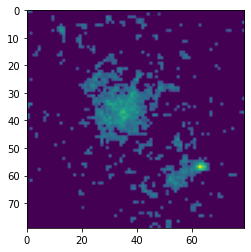

In [ ]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            # remove later to process all
            if slic == slice_target and rec == rec_target:

                snr = single_images[slic][loc]['SNR'][rec]
                sampled_points = generate_points(snr, n_points=100000, percentile_cutoff=85)

                w, h = snr.shape
                heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                k = 85
                
                if k is None:
                    # use AIC and elbow method, then enter choice of k above
                    find_gmm_cluster_number(sampled_points, k_start=130, k_step=20, k_search=250)
                else: # after manually selecting k
                    labels = gaussian_mixture_model(sampled_points, k, show=False)
                    draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)
